In [2]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import bz2
import multiprocessing as mp


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import auc

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# Extracting the point collection and the descriptors

In [3]:
with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)
    
with open('descriptors/new_complete_RANSAC_res5_4by5_descriptors.pickle','rb') as f:
    ransac_descriptors = pickle.load(f)
    
results_path = 'testing_results'

if not os.path.exists(results_path): os.mkdir(results_path)
    
obj_names = []

for obj_name, pointCloud, triangles in new_contiguous_point_collection:
    obj_names.append(obj_name)
    
contiguous_names_short = [
    'Recpt\'n',
    'Drvway',
    'Aprtmnt',
    'Wrkst\'n',
    'Kitchen',
    'Hallway',
    'Strwell',
]

contiguous_names = [
    'Reception',
    'Driveway',
    'Apartment',
    'Workstation',
    'Kitchen',
    'Hallway',
    'Stairwell',
]

colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:cyan",
    "tab:olive",
    "tab:gray",
    "tab:pink",
    "tab:brown"
]



['Reception-Data61-L5.obj',
 'Driveway.obj',
 'Apartment.obj',
 'Workstations-Data61-L4.obj',
 'Kitchen-Data61-L4.obj',
 'HallWayToKitchen-Data61-L4.obj',
 'StairWell-Data61-L4.obj']

# Performance scores

In [4]:
#ISMAR Performance

with open("ismar_testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'rb') as f:
    arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores = pickle.load(f)
    
with open("ismar_testing_results/pointnetvlad_prod/" + "summary_results_updated.pickle",'rb') as f:
    pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores = pickle.load(f)
    
with open("ismar_testing_results/partial/" + "summary_results_1000.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)
    
with open("ismar_testing_results/nn_matcher_arcore/" + "summary_results.pickle",'rb') as f:
    arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores = pickle.load(f)


In [4]:
#Reruns Performance

with open("testing_results/pointnetvlad/arcore_summary_results.pickle",'rb') as f:
    arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores = pickle.load(f)
    
with open("testing_results/pointnetvlad/hololens_summary_results.pickle",'rb') as f:
    pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores = pickle.load(f)
    
with open("testing_results/nn_matcher/hololens_results_partials_nn_matcher.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)
    
with open("testing_results/nn_matcher/arcore_results_partials_nn_matcher.pickle",'rb') as f:
    arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores = pickle.load(f)


# The Normal Similarity CDF with varying neighborhood size

In [7]:
"""
For the computation of normal vector similarity:
1. For every keypoint, we get the K nearest neighboring points of and 
2. compute the average cosine similarity of their normals with that of the keypoint.
3. We vary the neighbor size K to see how the normal similarity varies accordingly.
"""

raw_norm_cdf_values = []

neighbor_sizes = 50*2**np.arange(0,6)

for obj_name, t_pointCloud, triangles in new_contiguous_point_collection:

    pointCloud = getQuantizedPointCloudOnlyTEST(t_pointCloud,scale = 100)
    print("{}: from {} to {}.".format(obj_name, t_pointCloud.shape, pointCloud.shape))

    per_space_values = []

    for i, neighbor_size in enumerate(neighbor_sizes):

        t0 = time.time()

        nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='kd_tree').fit(pointCloud[:,:3])
        distances, indices = nbrs.kneighbors(pointCloud[:,:3])
        
        print("  Max dist of {} = {:.3f} m (± {:.3f} m)".format(
            neighbor_size,
            np.mean(np.amax(distances,axis =1)),
            np.std(np.amax(distances,axis =1))
        ))
        
        try:
            nearby_normals = pointCloud[indices,3:6]
            refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],neighbor_size,axis=0),nearby_normals.shape)

            normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)
            
            #print(nearby_normals.shape, refrnc_normals.shape, normal_product.shape)
        except Exception as e1:
            print("Error while getting normals,", e1)

        color = np.mean(np.abs(normal_product))
        hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
        CY = np.cumsum(hist/np.sum(hist))
        
        per_space_values.append([
            hist,
            CY,
            values,
            np.trapz(CY, values[1:]),
            neighbor_size
        ])

    print("Done with {} in {:.3f} seconds".format(obj_name,time.time()-t0))
    
    raw_norm_cdf_values.append([
        obj_name,
        per_space_values
    ])
    
with open("properties/raw_cdf_values_sampled.pickle",'wb') as f:
    pickle.dump(raw_norm_cdf_values,f)

Reception-Data61-L5.obj: from (40491, 6) to (39848, 6).
  Max dist of 50 = 0.219 m (± 0.094 m)
  Max dist of 100 = 0.314 m (± 0.120 m)
  Max dist of 200 = 0.451 m (± 0.157 m)
  Max dist of 400 = 0.648 m (± 0.204 m)
  Max dist of 800 = 0.927 m (± 0.257 m)
  Max dist of 1600 = 1.316 m (± 0.300 m)
Done with Reception-Data61-L5.obj in 16.839 seconds
Driveway.obj: from (56926, 6) to (55378, 6).
  Max dist of 50 = 0.193 m (± 0.074 m)
  Max dist of 100 = 0.274 m (± 0.105 m)
  Max dist of 200 = 0.388 m (± 0.150 m)
  Max dist of 400 = 0.551 m (± 0.218 m)
  Max dist of 800 = 0.772 m (± 0.297 m)
  Max dist of 1600 = 1.089 m (± 0.400 m)
Done with Driveway.obj in 23.735 seconds
Apartment.obj: from (72859, 6) to (71366, 6).
  Max dist of 50 = 0.184 m (± 0.062 m)
  Max dist of 100 = 0.258 m (± 0.079 m)
  Max dist of 200 = 0.357 m (± 0.101 m)
  Max dist of 400 = 0.491 m (± 0.134 m)
  Max dist of 800 = 0.675 m (± 0.162 m)
  Max dist of 1600 = 0.934 m (± 0.209 m)
Done with Apartment.obj in 33.080 second

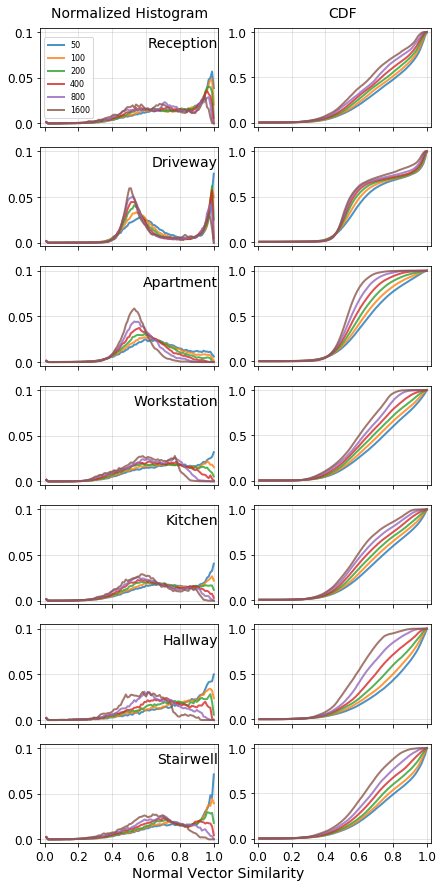

In [13]:
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/raw_cdf_values_sampled.pickle",'rb') as f:
    raw_norm_cdf_values_sampled = pickle.load(f)

fig=plt.figure(figsize=(7, 15)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

figures_list = []

for n in np.arange(7):    
    figures_list.append([
        fig.add_subplot(7,2,n*2+1), # normalized histogram (estimate PDF)
        fig.add_subplot(7,2,n*2+2) # estimate CDF
    ])
    
raw_sim_dist_values = [] # auc and sim dist ratio

for i, [obj_name, per_space_values] in enumerate(raw_norm_cdf_values_sampled):
    
    ax1, ax2 = figures_list[i]

    per_space_dist_values = []
    
    ax1.text(
        1.0,.8,contiguous_names[i],
        horizontalalignment='right',
        fontsize = 14,
        transform=ax1.transAxes
    )
    
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(-0.025,1.025)
    ax2.set_xlim(-0.025,1.025)
    
    if i == 0:
        ax1.text(
            0.5,1.1,
            "Normalized Histogram",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )
        ax2.text(
            0.5,1.1,                
            "CDF",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax2.transAxes
        )

    ax1.set_xticks(np.arange(0,1.1,0.2))
    ax2.set_xticks(np.arange(0,1.1,0.2))
    ax1.set_yticks(np.arange(0.0,0.11,0.05))
    ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        ax2.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        ax1.text(
            1.0,-0.35,"Normal Vector Similarity",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes
        )

    ax1.set_yticklabels(np.around(np.arange(0.0,0.11,0.05),decimals = 2), fontsize = 12)
    ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 2), fontsize = 12)

    ax1.grid(alpha=0.4)
    ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
            
        ax2.plot(
            values[1:], 
            cum_y, 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
        
        per_space_dist_values.append([
            np.sum(hist[90:])/np.sum(hist[:90]),
            np.sum(hist[50:])/np.sum(hist[:50]),
            np.sum(hist[95:])/np.sum(hist),
            np.sum(hist[:92])/np.sum(hist)
        ])
        
    if i == 0:
        ax1.legend(loc = "center left", 
            ncol = 1, fontsize = 8)#bbox_to_anchor=(0.6, 1.03))

    #print("Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
    
    raw_sim_dist_values.append(per_space_dist_values)
    
#plt.show()
plt.savefig('properties/raw-norm-sim-hist-cdf-sampled.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/raw-norm-sim-hist-cdf-sampled.png', format='png', dpi=300,bbox_inches = 'tight')


# For the (RANSAC) query sub maps

In [ ]:

radius = 2.0
    
t0 = time.time()
t1 = t0

norm_cdf_values = []

print("radius =",radius)

for obj_, object_name, original_vertex in sample_points:

    pointCloud = []

    try:
        trial = np.random.randint(5)

        with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
            ransac_trial_point_collection = pickle.load(f)

        object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]

        ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])

        dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
        pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
    except:
        print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
        continue

    if len(pointCloud) == 0: continue

    per_space_values = []

    for neighbor_size in neighbor_sizes:

        t0 = time.time()

        nbrs = NearestNeighbors(n_neighbors=min(neighbor_size,len(pointCloud)), algorithm='kd_tree').fit(pointCloud[:,:3])
        distances, indices = nbrs.kneighbors(pointCloud[:,:3])

        try:
            nearby_normals = pointCloud[indices,3:6]
            refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],min(neighbor_size,len(pointCloud)),axis=0),nearby_normals.shape)

            normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)

            #print(nearby_normals.shape, refrnc_normals.shape, normal_product.shape)
        except Exception as e1:
            print("Error while getting normals,", e1)

        color = np.mean(np.abs(normal_product))
        hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
        hist_all, values_all = np.histogram(np.abs(normal_product), bins = np.arange(0,1.01,0.01))
        CY = np.cumsum(hist/np.sum(hist))

        per_space_values.append([
            hist,
            CY,
            values,
            hist_all, 
            values_all,
            neighbor_size,
            len(pointCloud)
        ])

    norm_cdf_values.append([
        [obj_, object_name, original_vertex],
        per_space_values
    ])

    if len(norm_cdf_values) % 66 == 2:

        print("  ",radius,": Done with {}, in {:.3f} seconds.".format(
            len(norm_cdf_values),
            time.time()-t1
        ))

        t1 = time.time()

    with bz2.BZ2File('testing_results/partial/ransac_{}_partial_sim_hist.pickle.bz2'.format(radius), 'w') as bz2_f:
        pickle.dump(norm_cdf_values, bz2_f)

print(radius," Total Time to compute similarities {:.3f} seconds.".format(time.time()-t0))


# Looking into the impact of generalizations to Normal similarity

In [260]:
linewidth = 5

ransac_norm_cdf_values = []

neighbor_sizes = 50*2**np.arange(6)

t0 = time.time()
    
for trial in np.arange(5):

    per_trial_values = []

    with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
        ransac_trial_point_collection = pickle.load(f)

    for obj_name, pointCloud, triangles in ransac_trial_point_collection:

        per_neighbor_values = []

        for i, neighbor_size in enumerate(neighbor_sizes):

            #neighbor_size = 30

            nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='kd_tree').fit(pointCloud[:,:3])
            distances, indices = nbrs.kneighbors(pointCloud[:,:3])

            try:
                nearby_normals = pointCloud[indices,3:6]
                refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],neighbor_size,axis=0),nearby_normals.shape)

                normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)
            except Exception as e1:
                print("Error while getting normals,", e1)

            color = np.mean(np.abs(normal_product))
            hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
            CY = np.cumsum(hist/np.sum(hist))

            per_neighbor_values.append([
                hist,
                CY,
                values,
                np.trapz(CY, values[1:]),
                neighbor_size
            ])

        per_trial_values.append([
            obj_name,
            per_neighbor_values
        ])

        print(trial,obj_name,"  Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
        t0 = time.time()
        
    ransac_norm_cdf_values.append(per_trial_values)


0 Reception-Data61-L5.obj   Done with 1600 in 31.346 seconds
0 Driveway.obj   Done with 1600 in 43.981 seconds
0 Apartment.obj   Done with 1600 in 58.845 seconds
0 Workstations-Data61-L4.obj   Done with 1600 in 57.105 seconds
0 Kitchen-Data61-L4.obj   Done with 1600 in 78.468 seconds
0 HallWayToKitchen-Data61-L4.obj   Done with 1600 in 21.308 seconds
0 StairWell-Data61-L4.obj   Done with 1600 in 60.119 seconds
1 Reception-Data61-L5.obj   Done with 1600 in 31.431 seconds
1 Driveway.obj   Done with 1600 in 44.412 seconds
1 Apartment.obj   Done with 1600 in 57.846 seconds
1 Workstations-Data61-L4.obj   Done with 1600 in 57.362 seconds
1 Kitchen-Data61-L4.obj   Done with 1600 in 80.265 seconds
1 HallWayToKitchen-Data61-L4.obj   Done with 1600 in 21.113 seconds
1 StairWell-Data61-L4.obj   Done with 1600 in 60.476 seconds
2 Reception-Data61-L5.obj   Done with 1600 in 23.737 seconds
2 Driveway.obj   Done with 1600 in 42.397 seconds
2 Apartment.obj   Done with 1600 in 60.052 seconds
2 Workstat

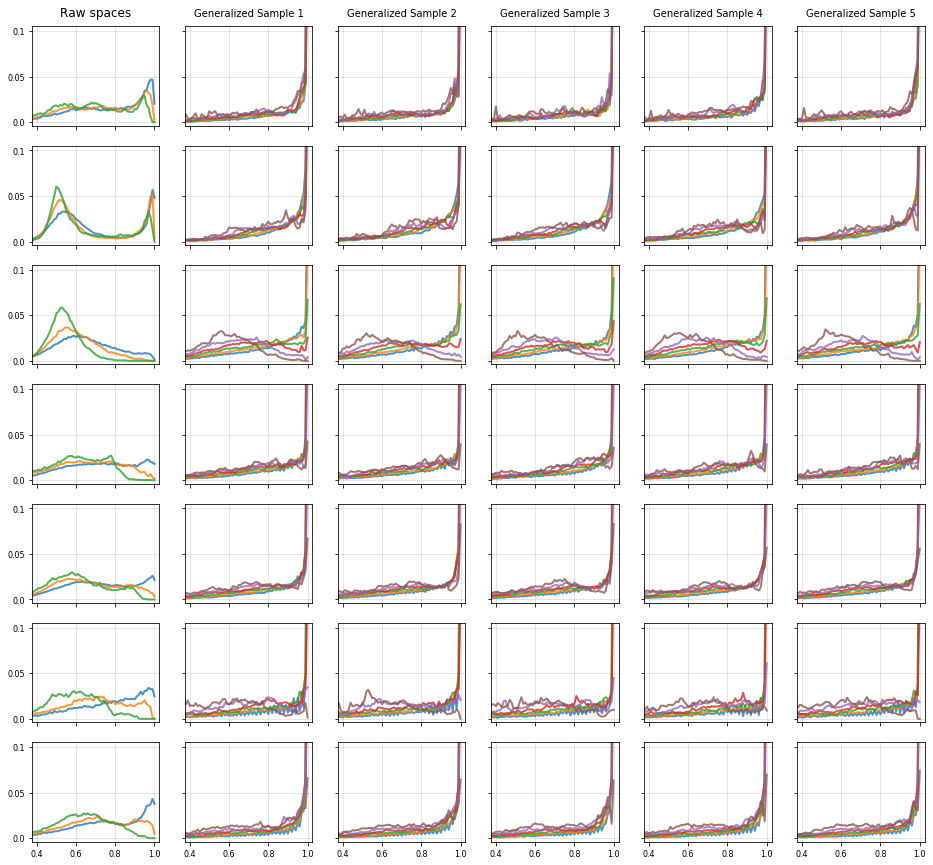

In [6]:
"""
Plotting the (estimate) PDF, i.e. normalized histogram, for Raw and Generalized spaces
"""

with open("properties/raw_cdf_values_sampled.pickle",'rb') as f:
    raw_norm_cdf_values = pickle.load(f)
    
with open("properties/ransac_cdf_values.pickle",'rb') as f:
    ransac_norm_cdf_values = pickle.load(f)

fig=plt.figure(figsize=(16, 15)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

figures_list = []

neighbor_sizes = 50*2**np.arange(6)

for n in np.arange(7):    
    figures_list.append([
        fig.add_subplot(7,6,n*6+1),
        fig.add_subplot(7,6,n*6+2),
        fig.add_subplot(7,6,n*6+3),
        fig.add_subplot(7,6,n*6+4),
        fig.add_subplot(7,6,n*6+5),
        fig.add_subplot(7,6,n*6+6),
    ])
    
for i_n, per_neighbor_values in enumerate(raw_norm_cdf_values[1::2]):

    per_neighbor_dist_values = []
    per_neighbor_legends = []
    
    for i_s, [hist, cum_y, values, auc] in enumerate(per_neighbor_values):
        
        ax1 = figures_list[i_s][0]

        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(neighbor_sizes[i_n+2])
        )
        
        ax1.set_ylim(-0.004,0.105)
        ax1.set_xlim(0.375,1.025)
        
        if i_s == 0 and i_n == 0:
            ax1.text(
                0.5,1.1,
                "Raw spaces",
                horizontalalignment='center',
                fontsize = 12,
                transform=ax1.transAxes                
            )

        if i_n == len(neighbor_sizes)-3:
            ax1.text(
                .7,.8,contiguous_names[i_s],
                horizontalalignment='center',
                fontsize = 12,
                transform=ax1.transAxes
            )
        
        ax1.set_xticks(np.arange(0.4,1.1,0.2))
        ax1.set_yticks(np.arange(0.0,0.11,0.05))

        if i_s != 6: 
            ax1.set_xticklabels([])
        else:
            ax1.set_xticklabels(np.around(np.arange(0.4,1.1,0.2), decimals = 1), fontsize = 8)

        ax1.set_yticklabels(np.arange(0.0,0.11,0.05), fontsize = 8)
        
        ax1.grid(alpha=0.4)
            
        if i_n == len(neighbor_sizes)-3 and i_s == 0:
            ax1.legend(loc = "upper left", ncol = 1, fontsize = 8)#, bbox_to_anchor=(0, 1.3))
    

# RANSAC
ransac_sim_dist_values = [] # auc and sim dist ratio

"""
                hist,
                CY,
                values,
                np.trapz(CY, values[1:]),
                neighbor_size
"""

for i_t, per_trial_values in enumerate(ransac_norm_cdf_values):

    per_neighbor_dist_values = []
    
    for i_s, [o_, per_neighbor_values] in enumerate(per_trial_values):
        
        per_trial_dist_values = []
        
        ax = figures_list[i_s][i_t+1]

        for i_n, [hist, cum_y, values, auc, size] in enumerate(per_neighbor_values):
            
            per_trial_dist_values.append([
                np.sum(hist[90:])/np.sum(hist[:90]),
                np.sum(hist[95:])/np.sum(hist[:95]),
                np.sum(hist[95:])/np.sum(hist),
                np.sum(hist[:92])/np.sum(hist)
            ])
            
            #if size not in [100, 400, 1600]: continue

            #color = np.mean(np.abs(normal_product))
            ax.plot(
                values[1:], 
                hist/np.sum(hist), 
                alpha = 0.8, 
                #color = colors[i_n-2], #mpl.cm.viridis(color), 
                linewidth = 2,
                label = str(size)
            )
            
            ax.grid(alpha=0.4)
            ax.set_ylim(-0.004,0.105)
            ax.set_xlim(0.375,1.025)
            
            ax.set_xticks(np.arange(0.4,1.1,0.2))
            ax.set_yticks(np.arange(0.0,0.11,0.05))
            
            if i_s == 0 and i_n == 4:
                ax.text(
                    0.5,1.1,
                    "Generalized Sample "+str(i_t+1),
                    horizontalalignment='center',
                    fontsize = 10,
                    transform=ax.transAxes                
                )
            
            if i_s != 6: 
                ax.set_xticklabels([])
            else:
                ax.set_xticklabels(np.around(np.arange(0.4,1.1,0.2), decimals = 1), fontsize = 8)
                
            #ax.set_yticklabels(np.arange(0.0,0.11,0.05), fontsize = 8)
            ax.set_yticklabels([])
            
            """
            if i_n == len(neighbor_sizes)-1 and i_s == 0:
                ax1.legend(loc = "upper left", ncol = 8, fontsize = 10, bbox_to_anchor=(0, 1.3))
                #ax2.legend(loc = "upper left", ncol = 2, fontsize = 8)
            """
            
        per_neighbor_dist_values.append(per_trial_dist_values)
        
    ransac_sim_dist_values.append(per_neighbor_dist_values)
    
    #sim_dist_values.append(per_neighbor_dist_values)

plt.savefig('properties/generalized-norm-sim.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/generalized-norm-sim.png', format='png', dpi=300,bbox_inches = 'tight')

#plt.show()


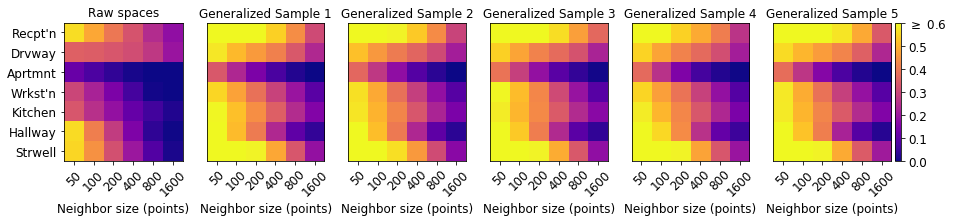

In [277]:
from matplotlib import gridspec

fig=plt.figure(figsize=(15,3.5))

ransac_sim_dist_values = np.asarray(ransac_sim_dist_values)
raw_sim_dist_values = np.asarray(raw_sim_dist_values)

gs = gridspec.GridSpec(1, 6, width_ratios=[1.01,1, 1, 1, 1, 1.085]) 

ax0 = plt.subplot(gs[0])#fig.add_subplot(1,6,1)

im0 = ax0.imshow(
    raw_sim_dist_values[:,:,0], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=0.6# np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);

ax0.set_xticks(np.arange(len(neighbor_sizes)))
ax0.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax0.set_xlabel("Neighbor size (points)",fontsize = 12)
ax0.set_title("Raw spaces", fontsize = 12)

ax0.set_yticks(np.arange(len(contiguous_names)))
ax0.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

for i_t in np.arange(ransac_sim_dist_values.shape[0]):
    
    ax = plt.subplot(gs[i_t+1])#fig.add_subplot(1,6,i_t+2)
    ax.set_aspect(1)

    im = ax.imshow(
        ransac_sim_dist_values[i_t,:,:,-1], 
        cmap=mpl.cm.plasma,
        vmin=0.0, vmax=0.6 #np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
    );
    
    ax.set_xticks(np.arange(len(neighbor_sizes)))
    ax.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
    ax.set_xlabel("Neighbor size (points)",fontsize = 12)
    
    ax.set_yticks([])
    ax.set_title("Generalized Sample "+str(i_t+1), fontsize = 12)

    """    
    if i_t == 0: 
        ax.set_yticks(np.arange(len(contiguous_names)))
        ax.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
    
    
    #ax.set_title("Ratio of (high/low) AUC\n of Normal similarity", fontsize = 14)
    """
    if i_t == np.arange(ransac_sim_dist_values.shape[0])[-1]:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax = cax, format="%.1f")
        cbar.ax.set_yticklabels(np.append(np.arange(0,0.6,0.1, dtype = np.float32),'$\geq$ 0.6'),fontsize = 12);

plt.savefig('properties/generalized-high-norm-sim-all.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/generalized-high-norm-sim-all.png', format='png', dpi=300,bbox_inches = 'tight')


# ARCore Spatial Properties

In [23]:
with open('point_collection/2_filled_quaternion_vertical_correction_arcore_point_cloud_collection_complete.pickle','rb') as f: 
    arcore_point_cloud_collection = pickle.load(f)
    
arcore_spaces = [[],[],[],[],[],[],[]]
    
for [obj_num, name, timestamp], t_pointCloud, triangles in arcore_point_cloud_collection:
    
    unique_normals = np.unique(np.around(t_pointCloud[:,3:],decimals = 2),axis = 0)
    
    #print(obj_num, name, timestamp, len(unique_normals))
    try:
        arcore_spaces[int(obj_num)].append([
            [obj_num, name, timestamp],
            t_pointCloud, 
            triangles,
            len(unique_normals)
        ])
    except:
        continue
        
        

7

In [40]:
arcore_norm_cdf_values = []

neighbor_sizes = 50*2**np.arange(0,6)

for space in arcore_spaces:
    
    per_space_values = []
    
    print(len(space))
    
    per_sample_most_planes = 0
    max_num_normals = 0

    for i_s, [[obj_num, obj_name, timestamp] , t_pointCloud, triangles, num_normals] in enumerate(space):
        
        per_sample_space_values = []

        pointCloud = getQuantizedPointCloudOnlyTEST(t_pointCloud,scale = 100)
        print("{}: from {} to {}.".format(obj_name+timestamp, t_pointCloud.shape, pointCloud.shape))

        if num_normals > max_num_normals: 
            max_num_normals = num_normals
            per_sample_most_planes = i_s

        for i, neighbor_size in enumerate(neighbor_sizes):

            t0 = time.time()

            nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='kd_tree').fit(pointCloud[:,:3])
            distances, indices = nbrs.kneighbors(pointCloud[:,:3])

            print("  Max dist of {} = {:.3f} m (± {:.3f} m)".format(
                neighbor_size,
                np.mean(np.amax(distances,axis =1)),
                np.std(np.amax(distances,axis =1))
            ))

            try:
                nearby_normals = pointCloud[indices,3:6]
                refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],neighbor_size,axis=0),nearby_normals.shape)

                normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)

                #print(nearby_normals.shape, refrnc_normals.shape, normal_product.shape)
            except Exception as e1:
                print("Error while getting normals,", e1)

            color = np.mean(np.abs(normal_product))
            hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
            CY = np.cumsum(hist/np.sum(hist))

            per_sample_space_values.append([
                hist,
                CY,
                values,
                np.trapz(CY, values[1:]),
                neighbor_size
            ])

        print("Done with {} in {:.3f} seconds".format(obj_name,time.time()-t0))
        
        per_space_values.append(per_sample_space_values)

    arcore_norm_cdf_values.append([
        [obj_num, obj_name],
        per_space_values,
        per_sample_most_planes
    ])

    with open("properties/arcore_cdf_values_sampled.pickle",'wb') as f:
        pickle.dump(arcore_norm_cdf_values,f)
    

5
reception2020.01.14.12.10.53: from (19768, 6) to (14056, 6).
  Max dist of 50 = 0.305 m (± 0.094 m)
  Max dist of 100 = 0.436 m (± 0.127 m)
  Max dist of 200 = 0.623 m (± 0.171 m)
  Max dist of 400 = 0.896 m (± 0.236 m)
  Max dist of 800 = 1.288 m (± 0.305 m)
  Max dist of 1600 = 1.874 m (± 0.398 m)
Done with reception in 5.656 seconds
reception2020.01.14.12.12.31: from (15860, 6) to (12211, 6).
  Max dist of 50 = 0.302 m (± 0.094 m)
  Max dist of 100 = 0.432 m (± 0.130 m)
  Max dist of 200 = 0.613 m (± 0.167 m)
  Max dist of 400 = 0.874 m (± 0.210 m)
  Max dist of 800 = 1.276 m (± 0.279 m)
  Max dist of 1600 = 1.907 m (± 0.401 m)
Done with reception in 4.834 seconds
reception2020.01.14.12.13.59: from (18088, 6) to (12513, 6).
  Max dist of 50 = 0.312 m (± 0.079 m)
  Max dist of 100 = 0.446 m (± 0.107 m)
  Max dist of 200 = 0.639 m (± 0.144 m)
  Max dist of 400 = 0.920 m (± 0.193 m)
  Max dist of 800 = 1.341 m (± 0.264 m)
  Max dist of 1600 = 2.011 m (± 0.370 m)
Done with reception i

  Max dist of 100 = 0.458 m (± 0.143 m)
  Max dist of 200 = 0.656 m (± 0.193 m)
  Max dist of 400 = 0.943 m (± 0.268 m)
  Max dist of 800 = 1.372 m (± 0.385 m)
  Max dist of 1600 = 1.996 m (± 0.542 m)
Done with kitchen in 7.622 seconds
kitchen2020.01.14.14.06.43: from (30756, 6) to (15603, 6).
  Max dist of 50 = 0.386 m (± 0.088 m)
  Max dist of 100 = 0.559 m (± 0.148 m)
  Max dist of 200 = 0.806 m (± 0.192 m)
  Max dist of 400 = 1.164 m (± 0.266 m)
  Max dist of 800 = 1.685 m (± 0.373 m)
  Max dist of 1600 = 2.468 m (± 0.512 m)
Done with kitchen in 6.223 seconds
5
hallway2020.01.14.12.03.42: from (7999, 6) to (4363, 6).
  Max dist of 50 = 0.381 m (± 0.196 m)
  Max dist of 100 = 0.547 m (± 0.212 m)
  Max dist of 200 = 0.800 m (± 0.242 m)
  Max dist of 400 = 1.208 m (± 0.311 m)
  Max dist of 800 = 1.958 m (± 0.580 m)
  Max dist of 1600 = 3.446 m (± 1.559 m)
Done with hallway in 1.577 seconds
hallway2020.01.14.12.04.42: from (10928, 6) to (8080, 6).
  Max dist of 50 = 0.283 m (± 0.081 m)

reception 3
driveway 4
apartment 2
workstation 4
kitchen 2
hallway 0
stairwell 0


/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in long_scalars
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in long_scalars


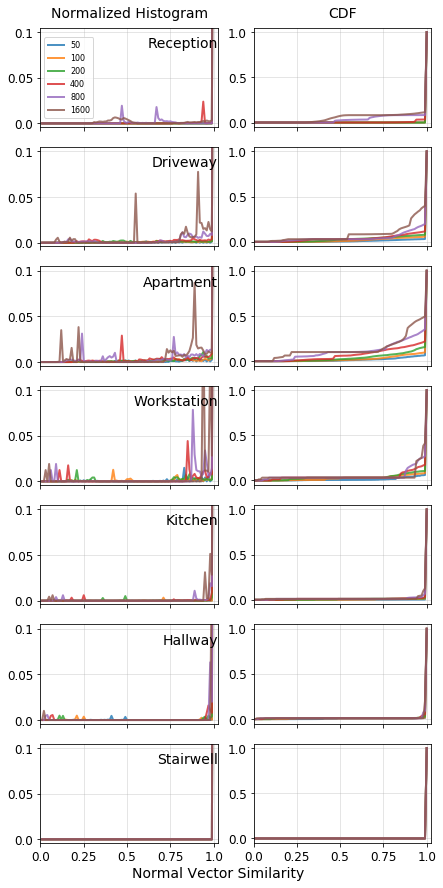

In [24]:
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/arcore_cdf_values_sampled.pickle",'rb') as f:
    norm_cdf_values = pickle.load(f)

fig=plt.figure(figsize=(7, 15)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

figures_list = []

for n in np.arange(7):    
    figures_list.append([
        fig.add_subplot(7,2,n*2+1), # normalized histogram (estimate PDF)
        fig.add_subplot(7,2,n*2+2) # estimate CDF
    ])
    
arcore_sim_dist_values = [] # auc and sim dist ratio

for i, [[obj_num, obj_name], per_space_samples, ind_at_max] in enumerate(norm_cdf_values):
    
    print(obj_name,ind_at_max)
    per_space_values = per_space_samples[ind_at_max]
    
    ax1, ax2 = figures_list[i]

    per_space_dist_values = []
    
    ax1.text(
        1.0,.8,contiguous_names[i],
        horizontalalignment='right',
        fontsize = 14,
        transform=ax1.transAxes
    )
    
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(0.375,1.025)
    ax2.set_xlim(0.375,1.025)
    
    if i == 0:
        ax1.text(
            0.5,1.1,
            "Normalized Histogram",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )
        ax2.text(
            0.5,1.1,                
            "CDF",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax2.transAxes
        )

    ax1.set_xticks(np.arange(0,1.1,0.25))
    ax2.set_xticks(np.arange(0,1.1,0.25))
    ax1.set_yticks(np.arange(0.0,0.11,0.05))
    ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.25), decimals = 2), fontsize = 12)
        ax2.set_xticklabels(np.around(np.arange(0,1.1,0.25), decimals = 2), fontsize = 12)
        ax1.text(
            1.0,-0.35,"Normal Vector Similarity",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes
        )

    ax1.set_yticklabels(np.around(np.arange(0.0,0.11,0.05),decimals = 2), fontsize = 12)
    ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 2), fontsize = 12)

    ax1.grid(alpha=0.4)
    ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
            
        ax2.plot(
            values[1:], 
            cum_y, 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
        
        per_space_dist_values.append([
            np.sum(hist[95:])/np.sum(hist[:95]),
            np.sum(hist[50:])/np.sum(hist[:50]),
            np.sum(hist[95:])/np.sum(hist),
            np.sum(hist[:92])/np.sum(hist)
        ])
        
    if i == 0:
        ax1.legend(loc = "center left", 
            ncol = 1, fontsize = 8)#bbox_to_anchor=(0.6, 1.03))

    #print("Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
    
    arcore_sim_dist_values.append(per_space_dist_values)
    
#plt.show()
plt.savefig('properties/arcore-norm-sim-hist-cdf.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/arcore-norm-sim-hist-cdf.png', format='png', dpi=300,bbox_inches = 'tight')


# Example Holo-Raw, HOlo-Gen, and ARCore similaity distribution

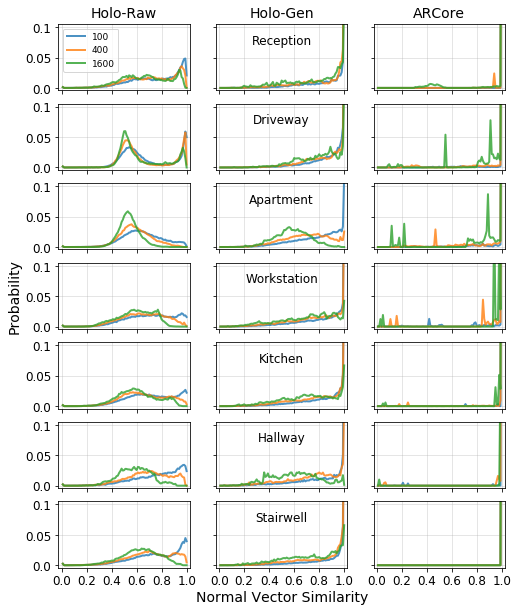

In [10]:
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/raw_cdf_values_sampled.pickle",'rb') as f:
    raw_norm_cdf_values_sampled = pickle.load(f)

fig=plt.figure(figsize=(8, 10)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

count = 0

medians = []

for i, [obj_name, per_space_values] in enumerate(raw_norm_cdf_values_sampled):
    
    raw_medians = []
    #if i not in [1,2,6]: continue
    
    ax1 = fig.add_subplot(7,3,i*3+1) # normalized histogram (estimate PDF)
    #ax2 = fig.add_subplot(3,2,count*2+2) #figures_list[i]

    #count += 1
    
    per_space_dist_values = []
    """
    ax1.text(
        0.4,.7,contiguous_names[i],
        horizontalalignment='left',
        fontsize = 14,
        transform=ax1.transAxes
    )
    """
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(-0.025,1.025)
    #ax2.set_xlim(-0.025,1.025)
    
    if i == 0:
        ax1.text(
            0.5,1.1,
            "Holo-Raw",#"Normalized Histogram",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )
        
    if i == 3:
        ax1.set_ylabel("Probability", fontsize = 14)

    ax1.set_xticks(np.arange(0,1.1,0.2))
    #ax2.set_xticks(np.arange(0,1.1,0.2))
    ax1.set_yticks(np.arange(0.0,0.11,0.05))
    #ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        #ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        #ax2.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)

    ax1.set_yticklabels(np.around(np.arange(0.0,0.11,0.05),decimals = 2), fontsize = 12)
    #ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 1), fontsize = 12)

    ax1.grid(alpha=0.4)
    #ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values[1::2]:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
        raw_medians.append([
            radius,
            np.where(cum_y>=0.5)[0][0],
            values[np.where(cum_y>=0.5)[0][0]]
        ])
        #print("raw",radius,np.where(cum_y>=0.5)[0][0],values[np.where(cum_y>=0.5)[0][0]])
        
    if i == 0:
        ax1.legend(loc = "upper left", 
            ncol = 1, fontsize = 9)#bbox_to_anchor=(0.6, 1.03))

    #print("Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
   
    medians.append(raw_medians)
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/arcore_cdf_values_sampled.pickle",'rb') as f:
    arcore_norm_cdf_values = pickle.load(f)

count = 0

for i, [[obj_num, obj_name], per_space_samples, ind_at_max] in enumerate(arcore_norm_cdf_values):
    
    #if i not in [1,2,6]: continue
    arcore_medians = []
    
    ax1 = fig.add_subplot(7,3,i*3+3) # normalized histogram (estimate PDF)
    
    #count += 1

    per_space_values = per_space_samples[ind_at_max]
    
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(-0.025,1.025)
    
    """
    ax1.text(
        0.4,.7,contiguous_names[i],
        horizontalalignment='left',
        fontsize = 14,
        transform=ax1.transAxes
    )
    """
    
    if i == 0:
        ax1.text(
            0.5,1.1,
            "ARCore",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )

    ax1.set_xticks(np.arange(0,1.1,0.2))
    #ax2.set_xticks(np.arange(0,1.1,0.25))
    ax1.set_yticks(np.arange(0.0,0.11,0.05))
    #ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        #ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        #ax2.set_xticklabels(np.around(np.arange(0,1.1,0.25), decimals = 2), fontsize = 12)

    ax1.set_yticklabels([])#ax1.set_yticklabels(np.around(np.arange(0.0,0.21,0.05),decimals = 2), fontsize = 12)
    #ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 2), fontsize = 12)

    ax1.grid(alpha=0.4)
    #ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values[1::2]:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
        
        #print("arcore",radius,np.where(cum_y>=0.5)[0][0],values[np.where(cum_y>=0.5)[0][0]])
        arcore_medians.append([
            radius,
            np.where(cum_y>=0.5)[0][0],
            values[np.where(cum_y>=0.5)[0][0]]
        ])
        
    medians.append(arcore_medians)
    
with open("properties/ransac_cdf_values.pickle",'rb') as f:
    ransac_norm_cdf_values = pickle.load(f)
    
count = 0
        
for i, [obj_name, per_space_values] in enumerate(ransac_norm_cdf_values[0]):
    
    #if i not in [1,2,6]: continue
    ransac_medians = []
    
    ax1 = fig.add_subplot(7,3,i*3+2) # normalized histogram (estimate PDF)
    #ax2 = fig.add_subplot(3,2,count*2+2) #figures_list[i]

    #count += 1
    
    per_space_dist_values = []
    
    ax1.text(
        0.5,.7,contiguous_names[i],
        horizontalalignment='center',
        fontsize = 12,
        transform=ax1.transAxes
    )
    
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(-0.025,1.025)
    #ax2.set_xlim(-0.025,1.025)
    
    if i == 0:
        ax1.text(
            0.5,1.1,
            "Holo-Gen",#"Normalized Histogram",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )

    ax1.set_xticks(np.arange(0,1.1,0.2))
    #ax2.set_xticks(np.arange(0,1.1,0.2))
    ax1.set_yticks(np.arange(0.0,0.11,0.05))
    #ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        #ax1.set_xticklabels([])
        #ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        #ax2.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        ax1.text(
            0.5,-0.5,"Normal Vector Similarity",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes
        )

    ax1.set_yticklabels([])#np.around(np.arange(0.0,0.21,0.05),decimals = 2), fontsize = 12)
    #ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 1), fontsize = 12)

    ax1.grid(alpha=0.4)
    #ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values[1::2]:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
        #print("ransac",radius,np.where(cum_y>=0.5)[0][0],values[np.where(cum_y>=0.5)[0][0]])
        ransac_medians.append([
            radius,
            np.where(cum_y>=0.5)[0][0],
            values[np.where(cum_y>=0.5)[0][0]]
        ])
        
    medians.append(ransac_medians)
#plt.show()
plt.savefig('properties/norm-sim-hist-pdf_only-all.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/norm-sim-hist-pdf_only-all.png', format='png', dpi=300,bbox_inches = 'tight')


In [11]:
medians = np.asarray(medians)
print(medians.shape)
medians[7:,[1],:],np.mean(medians[7:,[1],-1])
np.mean(medians[:,[1],-1]),np.mean(medians[:7,[1],-1]),np.mean(medians[7:14,[1],-1]),np.mean(medians[14:,[1],-1])

(21, 3, 3)


(0.8309523809523809,
 0.6485714285714286,
 0.9900000000000001,
 0.8542857142857143)

# Correlation coefficient

In [25]:
raw_sim_dist_values = np.asarray(raw_sim_dist_values)
ransac_sim_dist_values = np.asarray(ransac_sim_dist_values)
arcore_sim_dist_values = np.asarray(arcore_sim_dist_values)

raw_sim_dist_values.shape, ransac_sim_dist_values.shape, arcore_sim_dist_values.shape

((7, 6, 4), (5, 7, 6, 4), (7, 6, 4))

In [26]:
# Of norm vec similarlity of RANSAC spaces VS per-space NNmatcher F1 score

ransac_sim_dist_values = np.asarray(ransac_sim_dist_values)

for i_r, per_radius in enumerate(nn_per_space_score[3:12:4,0]):
            
    for i_n, neighbor_size in enumerate(neighbor_sizes):
        
        if neighbor_size not in neighbor_sizes[1::2]: continue
        print(neighbor_size,i_r+1,np.corrcoef(ransac_sim_dist_values[0,:,i_n,-1],per_radius)[0,1])


100 1 0.48492788379958995
400 1 0.7323943755383923
1600 1 0.8245039471610343
100 2 0.7541721915194252
400 2 0.8850947017539712
1600 2 0.8816702818066027
100 3 0.6729055835090992
400 3 0.8102698979213178
1600 3 0.7996751022523768


In [27]:
# Of norm vec similarlity of Raw spaces VS per-space NNmatcher F1 score

for i_r, per_radius in enumerate(nn_per_space_score[3:12:4,0]):
            
    for i_n, neighbor_size in enumerate(neighbor_sizes):
        
        if neighbor_size not in neighbor_sizes[1::2]: continue
        print(neighbor_size,i_r+1,np.corrcoef(raw_sim_dist_values[:,i_n,-1],per_radius)[0,1])


100 1 0.36368841946398683
400 1 0.6739778580612151
1600 1 0.7477475811194686
100 2 0.6807905196252995
400 2 0.8291950426019495
1600 2 0.6989078356304674
100 3 0.651338523074021
400 3 0.8456562782639906
1600 3 0.7279696819257112


In [28]:
# Of norm vec similarlity of RANSAC Hololens spaces VS per-space pointnetvlad F1 score

for i_r, per_radius in enumerate(pointnetvlad_per_space_score[3:12:4,0]):
                
    for i_n, neighbor_size in enumerate(neighbor_sizes):
        
        if neighbor_size not in neighbor_sizes[1::2]: continue
        print(neighbor_size,i_r+1,np.around(np.corrcoef(ransac_sim_dist_values[0,:,i_n,-1],per_radius)[0,1], decimals = 3))


100 1 0.344
400 1 0.252
1600 1 0.076
100 2 0.505
400 2 0.493
1600 2 0.407
100 3 -0.287
400 3 -0.241
1600 3 -0.216


In [29]:
# Of norm vec similarlity of ARCore spaces VS per-space NNmatcher F1 score

for i_r, per_radius in enumerate(arcore_nn_per_space_score[3:12:4,0]):
            
    for i_n, neighbor_size in enumerate(neighbor_sizes):
        
        if neighbor_size not in neighbor_sizes[1::2]: continue
        print(neighbor_size,i_r+1,np.corrcoef(arcore_sim_dist_values[:,i_n,-1],per_radius)[0,1])


100 1 -0.7091475518073103
400 1 -0.6476622273535174
1600 1 -0.0987097803500444
100 2 -0.3975764221521598
400 2 -0.41889699060429963
1600 2 -0.24535961988025123
100 3 0.008061476155328812
400 3 -0.09711832602470594
1600 3 -0.4087785452835884


# Entropy

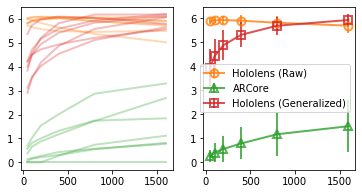

In [63]:
    
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/arcore_cdf_values_sampled.pickle",'rb') as f:
    arcore_norm_cdf_values = pickle.load(f)

overall_arcore_entropy = []

for i, [[obj_num, obj_name], per_space_samples, ind_at_max] in enumerate(arcore_norm_cdf_values):

    per_space_values = per_space_samples[ind_at_max]
    
    arcore_per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        arcore_per_space_entropy.append([
            radius,
            entropy
        ])
              
    arcore_per_space_entropy = np.asarray(arcore_per_space_entropy)
    overall_arcore_entropy.append(arcore_per_space_entropy)

    ax1.plot(
        arcore_per_space_entropy[:,0], 
        arcore_per_space_entropy[:,1], 
        alpha = 0.3, 
        color = colors[2], #mpl.cm.viridis(color), 
        linewidth = 2,
        label = "ARCore"
    )
    
with open("properties/ransac_cdf_values.pickle",'rb') as f:
    ransac_norm_cdf_values = pickle.load(f)
    
overall_ransac_entropy = []
            
for i, [obj_name, per_space_values] in enumerate(ransac_norm_cdf_values[0]):
    
    #per_space_values = per_space_samples[ind_at_max]
    
    ransac_per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        ransac_per_space_entropy.append([
            radius,
            entropy
        ])
              
    ransac_per_space_entropy = np.asarray(ransac_per_space_entropy)
    overall_ransac_entropy.append(ransac_per_space_entropy)
    
    ax1.plot(
        ransac_per_space_entropy[:,0], 
        ransac_per_space_entropy[:,1], 
        alpha = 0.3, 
        color = colors[3], #mpl.cm.viridis(color), 
        linewidth = 2,
        label = "Hololens (Generalized)"
    )
    
#ax1.legend()

overall_raw_entropy = np.asarray(overall_raw_entropy)
overall_ransac_entropy = np.asarray(overall_ransac_entropy)
overall_arcore_entropy = np.asarray(overall_arcore_entropy)

ax2.errorbar(
    raw_per_space_entropy[:,0], 
    np.mean(overall_raw_entropy[:,:,1], axis = 0), 
    np.std(overall_raw_entropy[:,:,1], axis = 0),
    marker = 'o', fillstyle = 'none', mew = 2,
    alpha = 0.8, 
    color = colors[1], #mpl.cm.viridis(color), 
    linewidth = 2, markersize = 8,
    label = "Hololens (Raw)"
)
ax2.errorbar(
    raw_per_space_entropy[:,0], 
    np.mean(overall_arcore_entropy[:,:,1], axis = 0), 
    np.std(overall_arcore_entropy[:,:,1], axis = 0), 
    marker = '^', fillstyle = 'none', mew = 2,
    alpha = 0.8, 
    color = colors[2], #mpl.cm.viridis(color), 
    linewidth = 2, markersize = 8,
    label = "ARCore"
)
ax2.errorbar(
    raw_per_space_entropy[:,0], 
    np.mean(overall_ransac_entropy[:,:,1], axis = 0), 
    np.std(overall_ransac_entropy[:,:,1], axis = 0), 
    marker = 's', fillstyle = 'none', mew = 2,
    alpha = 0.8, 
    color = colors[3], #mpl.cm.viridis(color), 
    linewidth = 2, markersize = 8,
    label = "Hololens (Generalized)"
)

ax2.legend()
#plt.show()
#plt.savefig('properties/raw-norm-sim-hist-pdf_only-example.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
#plt.savefig('properties/raw-norm-sim-hist-pdf_only-example.png', format='png', dpi=300,bbox_inches = 'tight')

(array([5.88187398, 5.92055772, 5.93261074, 5.90408774, 5.81931256,
        5.69616646]),
 array([3.95248007, 4.43512901, 4.88519306, 5.31939063, 5.6949048 ,
        5.9343299 ]),
 array([0.26221475, 0.40273805, 0.55764356, 0.78938325, 1.17019333,
        1.50491073]))

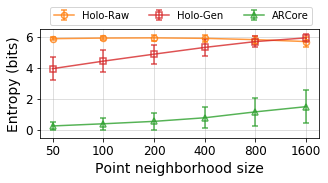

In [18]:
"""
Plotting the entripoy from the (estimate) PDF, i.e. normalized histogram
"""

with open("properties/raw_cdf_values_sampled.pickle",'rb') as f:
    raw_norm_cdf_values_sampled = pickle.load(f)

fig=plt.figure(figsize=(5, 2)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 1.5
markersize = 6
capsize = 3
mew = 1.5
#ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,1,1)

overall_raw_entropy = []

for i, [obj_name, per_space_values] in enumerate(raw_norm_cdf_values_sampled):
    
    raw_per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        raw_per_space_entropy.append([
            radius,
            entropy
        ])
                
    raw_per_space_entropy = np.asarray(raw_per_space_entropy)
    overall_raw_entropy.append(raw_per_space_entropy)


overall_arcore_entropy = []

for i, [[obj_num, obj_name], per_space_samples, ind_at_max] in enumerate(arcore_norm_cdf_values):

    per_space_values = per_space_samples[ind_at_max]
    
    arcore_per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        arcore_per_space_entropy.append([
            radius,
            entropy
        ])
              
    arcore_per_space_entropy = np.asarray(arcore_per_space_entropy)
    overall_arcore_entropy.append(arcore_per_space_entropy)
    
overall_ransac_entropy = []
            
for i, [obj_name, per_space_values] in enumerate(ransac_norm_cdf_values[0]):
    
    #per_space_values = per_space_samples[ind_at_max]
    
    ransac_per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        ransac_per_space_entropy.append([
            radius,
            entropy
        ])
              
    ransac_per_space_entropy = np.asarray(ransac_per_space_entropy)
    overall_ransac_entropy.append(ransac_per_space_entropy)

overall_raw_entropy = np.asarray(overall_raw_entropy)
overall_ransac_entropy = np.asarray(overall_ransac_entropy)
overall_arcore_entropy = np.asarray(overall_arcore_entropy)

ax2.errorbar(
    np.log10(raw_per_space_entropy[:,0]), 
    np.mean(overall_raw_entropy[:,:,1], axis = 0), 
    np.std(overall_raw_entropy[:,:,1], axis = 0),
    marker = 'o', fillstyle = 'none',  mew = mew,
    alpha = 0.8, capsize = capsize,
    color = colors[1], #mpl.cm.viridis(color), 
    linewidth = linewidth, markersize = markersize,
    label = "Holo-Raw"
)
ax2.errorbar(
    np.log10(raw_per_space_entropy[:,0]), 
    np.mean(overall_ransac_entropy[:,:,1], axis = 0), 
    np.std(overall_ransac_entropy[:,:,1], axis = 0), 
    marker = 's', fillstyle = 'none', mew = mew,
    capsize = capsize,
    alpha = 0.8, 
    color = colors[3], #mpl.cm.viridis(color), 
    linewidth = linewidth, markersize = markersize,
    label = "Holo-Gen"
)
ax2.errorbar(
    np.log10(raw_per_space_entropy[:,0]), 
    np.mean(overall_arcore_entropy[:,:,1], axis = 0), 
    np.std(overall_arcore_entropy[:,:,1], axis = 0), 
    marker = '^', fillstyle = 'none',  mew = mew,
    alpha = 0.8, 
    capsize = capsize,
    color = colors[2], #mpl.cm.viridis(color), 
    linewidth = linewidth, markersize = markersize,
    label = "ARCore"
)

ax2.legend(
    ncol = 3,
    #loc = "upper right", 
    fontsize = 10, 
    bbox_to_anchor=(0.995, 1.25)
);

ax2.set_ylim(-0.5,6.5)
ax2.grid(alpha = 0.5)
ax2.set_xticks(np.log10(raw_per_space_entropy[:,0]))
ax2.set_xticklabels(neighbor_sizes, fontsize = 12)

ax2.set_yticks(np.arange(0,7,2))
ax2.set_yticklabels(np.arange(0,7,2), fontsize = 12)

ax2.set_xlabel("Point neighborhood size", fontsize = 14)
ax2.set_ylabel("Entropy (bits)", fontsize =14)

plt.savefig('properties/sim-hist-entropy.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/sim-hist-entropy.png', format='png', dpi=300,bbox_inches = 'tight')

np.mean(overall_raw_entropy[:,:,1], axis = 0), np.mean(overall_ransac_entropy[:,:,1], axis = 0), np.mean(overall_arcore_entropy[:,:,1], axis = 0)


# Overall similarity scores

0.6837733386870106 0.00020380236993041605 0.0


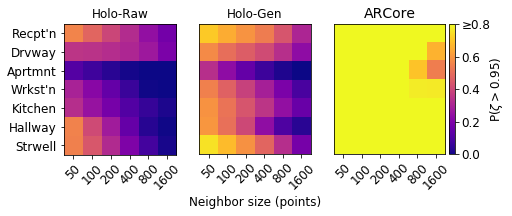

In [30]:
from matplotlib import gridspec

fig=plt.figure(figsize=(7,3.5))

ransac_sim_dist_values = np.asarray(ransac_sim_dist_values)
raw_sim_dist_values = np.asarray(raw_sim_dist_values)
arcore_sim_dist_values = np.asarray(arcore_sim_dist_values)

print(
    np.min(raw_sim_dist_values[:,:,-1]),
    np.min(ransac_sim_dist_values[:,:,-1]),
    np.min(arcore_sim_dist_values[:,:,-1])
)

gs = gridspec.GridSpec(1, 3, width_ratios=[1.01, 1, 1.085]) 

ax0 = plt.subplot(gs[0])#fig.add_subplot(1,6,1)

im0 = ax0.imshow(
    raw_sim_dist_values[:,:,0], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=0.8# np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);

ax0.set_xticks(np.arange(len(neighbor_sizes)))
ax0.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
#ax0.set_xlabel("Neighbor size (points)",fontsize = 12)
ax0.set_title("Holo-Raw", fontsize = 12)

ax0.set_yticks(np.arange(len(contiguous_names)))
ax0.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

    
ax1 = plt.subplot(gs[1])#fig.add_subplot(1,6,i_t+2)
ax1.set_aspect(1)

im = ax1.imshow(
    ransac_sim_dist_values[0,:,:,-2], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=0.8 #np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);

ax1.set_xticks(np.arange(len(neighbor_sizes)))
ax1.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax1.set_xlabel("Neighbor size (points)",fontsize = 12)

ax1.set_yticks([])
ax1.set_title("Holo-Gen", fontsize = 12)

ax2 = plt.subplot(gs[2])#fig.add_subplot(1,6,i_t+2)

im2 = ax2.imshow(
    arcore_sim_dist_values[:,:,-2], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=0.8,#np.around(np.max(raw_sim_dist_values[:,:,1]),decimals = 1)
);
ax2.set_xticks(np.arange(len(neighbor_sizes)))
ax2.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax2.set_yticks([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
#ax2.set_xlabel("Neighbor size (points)",fontsize = 12)
ax2.set_title("ARCore", fontsize = 14)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax = cax2, format="%.1f")
cbar2.ax.set_yticklabels(
    np.concatenate((np.around(np.arange(0,0.8,0.2), decimals = 1),['≥0.8'])),
    fontsize = 12
);
cbar2.ax.set_ylabel("P($\zeta > 0.95$)", fontsize = 12, labelpad = -2.5)

plt.savefig('properties/heatmap-high-norm-sim.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/heatmap-high-norm-sim.png', format='png', dpi=300,bbox_inches = 'tight')


1.0 0.9973651265030424 0.4162974683544304 
 0.6837733386870106 0.00020380236993041605 0.0


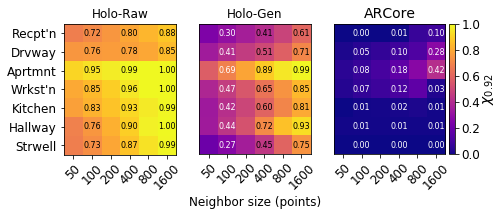

In [31]:
from matplotlib import gridspec

fig=plt.figure(figsize=(7,3.5))

ransac_sim_dist_values = np.asarray(ransac_sim_dist_values)
raw_sim_dist_values = np.asarray(raw_sim_dist_values)
arcore_sim_dist_values = np.asarray(arcore_sim_dist_values)

print(
    np.max(raw_sim_dist_values[:,:,-1]),
    np.max(ransac_sim_dist_values[:,:,-1]),
    np.max(arcore_sim_dist_values[:,:,-1]),'\n',
    np.min(raw_sim_dist_values[:,:,-1]),
    np.min(ransac_sim_dist_values[:,:,-1]),
    np.min(arcore_sim_dist_values[:,:,-1])
)

gs = gridspec.GridSpec(1, 3, width_ratios=[1.01, 1, 1.085]) 

ax0 = plt.subplot(gs[0])#fig.add_subplot(1,6,1)

im0 = ax0.imshow(
    raw_sim_dist_values[:,:,-1], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=1.0# np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);

ax0.set_xticks(np.arange(len(neighbor_sizes)))
ax0.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
#ax0.set_xlabel("Neighbor size (points)",fontsize = 12)
ax0.set_title("Holo-Raw", fontsize = 12)

ax0.set_yticks(np.arange(len(contiguous_names)))
ax0.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

    
ax1 = plt.subplot(gs[1])#fig.add_subplot(1,6,i_t+2)
ax1.set_aspect(1)

im = ax1.imshow(
    ransac_sim_dist_values[0,:,:,-1], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=1.0# np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);

ax1.set_xticks(np.arange(len(neighbor_sizes)))
ax1.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax1.set_xlabel("Neighbor size (points)",fontsize = 12)

ax1.set_yticks([])
ax1.set_title("Holo-Gen", fontsize = 12)

ax2 = plt.subplot(gs[2])#fig.add_subplot(1,6,i_t+2)

im2 = ax2.imshow(
    arcore_sim_dist_values[:,:,-1], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=1.0# np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);
ax2.set_xticks(np.arange(len(neighbor_sizes)))
ax2.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax2.set_yticks([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
#ax2.set_xlabel("Neighbor size (points)",fontsize = 12)
ax2.set_title("ARCore", fontsize = 14)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax = cax2, format="%.1f")
cbar2.ax.set_yticklabels(
    #np.concatenate((['≤0.2'],
    np.around(np.arange(0.0,1.1,0.2), decimals = 1),
    fontsize = 12
);
cbar2.ax.set_ylabel("$\chi_{0.92}$", fontsize = 14, labelpad = 0.5)

for i, per_space in enumerate(arcore_sim_dist_values):
    
    for j, values in enumerate(per_space[1::2]):
        
        color = 'white'
        
        #if i == 0: color = 'white'

        ax2.text(
            j*2+1, i,
            ha="center", va="center",
            s = "{:.2f}".format(values[-1]),
            fontsize = 8,
            color = color
        )

for i, per_space in enumerate(raw_sim_dist_values):
    
    for j, values in enumerate(per_space[1::2]):
        
        color = 'black'
        
        #if i == 0: color = 'white'

        ax0.text(
            j*2+1, i,
            ha="center", va="center",
            s = "{:.2f}".format(values[-1]),
            fontsize = 8,
            color = color
        )
        
for i, per_space in enumerate(ransac_sim_dist_values[0]):
    
    for j, values in enumerate(per_space[1::2]):
        
        color = 'black'
        
        if j == 0: color = 'white'

        ax1.text(
            j*2+1, i,
            ha="center", va="center",
            s = "{:.2f}".format(values[-1]),
            fontsize = 8,
            color = color
        )
        
plt.savefig('properties/heatmap-low-norm-sim-with-ann.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/heatmap-low-norm-sim-with-ann.png', format='png', dpi=300,bbox_inches = 'tight')

# Example spaces for presentation

4 (3424, 6) (5678, 3)


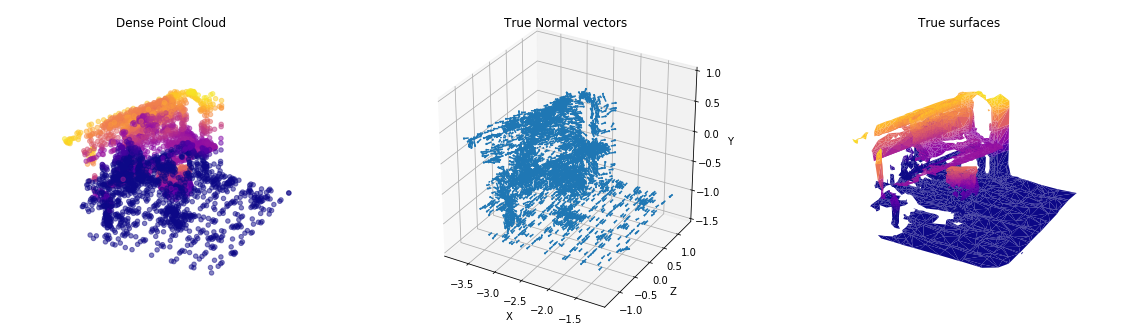

In [88]:
# pointCollection --> object_number, vertices, vertex normals, polygonswith open('many_ransac_generalizedPointCollection.pickle','rb') as f:

with open('../../mr-3d/centeredPointCollection.pickle','rb') as f:
    centeredPointCollection = pickle.load(f)
    
space = 3
sample = 9

fig=plt.figure(figsize=(20, 20)) ##fig=plt.figure(figsize=(80, 80))

descriptor_resolution = 10

ax0 = fig.add_subplot(3,3,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_zlim(-1.5,1)
ax0.set_title('Dense Point Cloud')

ax1 = fig.add_subplot(3,3,3, projection='3d')
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_zlabel('Y')
ax1.set_zlim(-1.5,1)
ax1.set_title('True surfaces')

ax4 = fig.add_subplot(3,3,2, projection='3d')
ax4.set_xlabel('X')
ax4.set_ylabel('Z')
ax4.set_zlabel('Y')
ax4.set_zlim(-1.5,1)
ax4.set_title('True Normal vectors')

object_name =  centeredPointCollection[space][0]
pointCloud = np.asarray(centeredPointCollection[space][1])
triangles = np.asarray(centeredPointCollection[space][2])

#pointCloud = np.concatenate((pointCloud,normals),axis = 1)

print(object_name,pointCloud.shape, triangles.shape)

t0 = time.time()

X = pointCloud[:,0]
Y = pointCloud[:,1]
Z = pointCloud[:,2]

ax0.set_xlim(min(X), max(X))
ax0.set_ylim(min(-Z), max(-Z))
ax1.set_xlim(min(X), max(X))
ax1.set_ylim(min(-Z), max(-Z))

try:
    imT = ax0.scatter(
        X,-Z,Y,
        c = Y,
        cmap = mpl.cm.plasma,
        vmin = -0.7, vmax = 0.35,
        alpha = 0.5
    )#,c=t_l_s_[:,-1])
    #imT.set_clim(0.0, 1.0)
    #cbarT = fig.colorbar(imT, ax=ax0)
    #cbarT.ax.set_ylabel('Local self-similarity ({} neighbors)'.format(len(t_k_[0])))

    ax1.plot_trisurf(
        X, -Z, Y, 
        triangles=triangles, 
        cmap=plt.cm.plasma,
        vmin = -0.7, vmax = 0.35
    )

    ax4.quiver(X, -Z, Y,
               pointCloud[:,3], -pointCloud[:,4], pointCloud[:,5],length=0.1)#, cmap=plt.cm.Spectral)

except Exception as ex:
    print(ex)
    pass

ax0.set_axis_off()
ax1.set_axis_off()


4 (2296, 6) (4349, 3)
vertical at 0.06
horizontal at 0.94 [-0.34 -0.94  0.01]
horizontal at 0.99 [-0.12  0.99  0.1 ]
horizontal at 1.0 [-0.03  1.   -0.01]
horizontal at 1.0 [ 0.   -1.   -0.04]
horizontal at 1.0 [ 0.03  1.   -0.03]
horizontal at 1.0 [ 0.03  1.   -0.01]
vertical at 0.15
horizontal at 0.97 [0.09 0.97 0.24]
horizontal at 1.0 [ 0.09  1.   -0.  ]
horizontal at 0.95 [0.27 0.95 0.13]
horizontal at 0.91 [ 0.39 -0.91 -0.13]
horizontal at 0.84 [ 0.51 -0.84  0.18]
vertical at 0.16
vertical at 0.05
vertical at 0.19
vertical at 0.02
vertical at 0.01


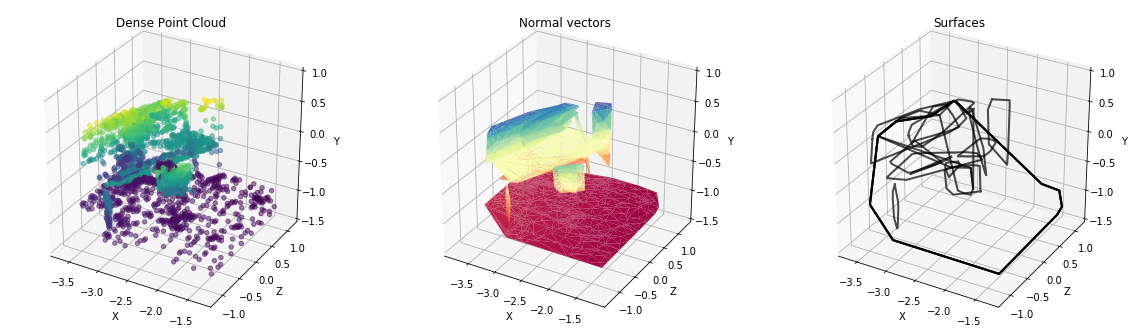

In [62]:
# Generalized

# pointCollection --> object_number, vertices, vertex normals, polygons
from scipy.spatial import ConvexHull, convex_hull_plot_2d

with open('../../mr-3d/many_ransac_generalizedPointCollection.pickle','rb') as f:
    many_ransac_generalizedPointCollection = pickle.load(f)
    
space = 3
sample = 5

fig=plt.figure(figsize=(20, 20)) ##fig=plt.figure(figsize=(80, 80))

descriptor_resolution = 10

ax0 = fig.add_subplot(3,3,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_zlim(-1.5,1)
ax0.set_title('Dense Point Cloud')

ax1 = fig.add_subplot(3,3,3, projection='3d')
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_zlabel('Y')
ax1.set_zlim(-1.5,1)
ax1.set_title('Surfaces')

ax4 = fig.add_subplot(3,3,2, projection='3d')
ax4.set_xlabel('X')
ax4.set_ylabel('Z')
ax4.set_zlabel('Y')
ax4.set_zlim(-1.5,1)
ax4.set_title('Normal vectors')

object_name =  many_ransac_generalizedPointCollection[space][0]
pointCloud = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][0])
triangles = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][1])

#pointCloud = np.concatenate((pointCloud,normals),axis = 1)

print(object_name,pointCloud.shape, triangles.shape)

t0 = time.time()

#pointCloud = getQuantizedPointCloudOnlyTEST(pointCloud, scale=100)

#print(pointCloud.shape)

X = pointCloud[:,0]
Y = pointCloud[:,1]
Z = pointCloud[:,2]

ax0.set_xlim(min(X), max(X))
ax0.set_ylim(min(-Z), max(-Z))
ax1.set_xlim(min(X), max(X))
ax1.set_ylim(min(-Z), max(-Z))

unique_normals = np.unique(np.around(pointCloud[:,3:],decimals = 2),axis = 0)

for normal in unique_normals:
    
    p_pointCloud = pointCloud[np.where(np.around(pointCloud[:,3:],decimals = 2) == normal)[0]]

    orientation  = np.abs(np.dot(normal,[0,1,0]))
    if orientation > 0.5 :
        print("horizontal at",orientation,normal)
        hull = ConvexHull(p_pointCloud[:,0:3:2])
    else:
        print("vertical at",orientation)
        hull = ConvexHull(p_pointCloud[:,0:2:1])
    
    #p_pointCloud = pointCloud[np.where(np.around(pointCloud[:,3:],decimals = 2) == normal)[0]]
    h_pointCloud = p_pointCloud[hull.vertices]

    PX = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,0]
    PY = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,1]
    PZ = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,2]

    #ax0.plot3D(PX,-PZ,PY,'k-',alpha = 0.7)
    ax1.plot3D(
        PX,-PZ,PY,
        'k-', linewidth = 2,
        alpha = 0.7)

try:
    imT = ax0.scatter(
        X,-Z,Y,
        c = Y,
        cmap = mpl.cm.viridis,
        alpha = 0.5
    )#,c=t_l_s_[:,-1])
    
    ax4.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    #imT.set_clim(0.0, 1.0)
    #cbarT = fig.colorbar(imT, ax=ax0)
    #cbarT.ax.set_ylabel('Local self-similarity ({} neighbors)'.format(len(t_k_[0])))

    #ax1.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    #ax4.quiver(X, -Z, Y,
    #           pointCloud[:,3], -pointCloud[:,4], pointCloud[:,5],length=0.1)#, cmap=plt.cm.Spectral)

except Exception as ex:
    print(ex)
    pass

4 (2189, 6) (4349, 3) 6
Plane area 5.832; point density 132.554.
horizontal at 0.9995100371773098 []
Plane area 2.188; point density 174.609.
horizontal at 0.999660486258831 []
Plane area 0.662; point density 362.400.
horizontal at 0.9963730470230381 []
Plane area 0.314; point density 264.104.
vertical at 0.14983159313150674 []
Plane area 0.858; point density 34.962.
Plane area 0.352; point density 73.877.



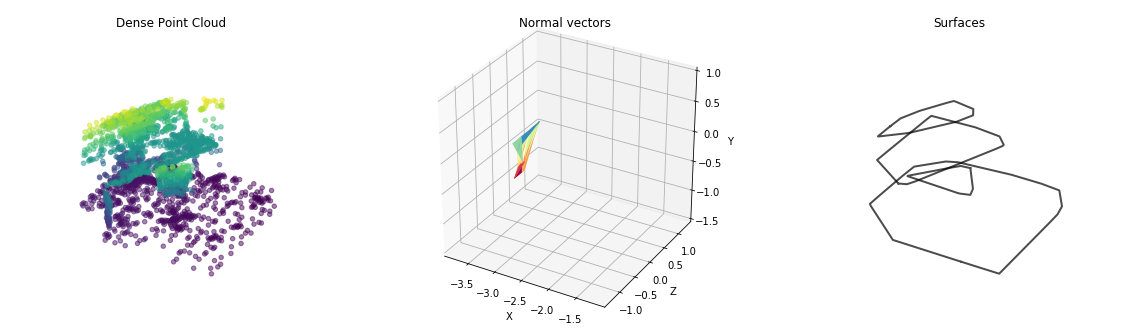

In [72]:
# Generalized

# pointCollection --> object_number, vertices, vertex normals, polygons
from scipy.spatial import ConvexHull, convex_hull_plot_2d

with open('../../mr-3d/many_ransac_generalizedPointCollection.pickle','rb') as f:
    many_ransac_generalizedPointCollection = pickle.load(f)
    
space = 3
sample = 5

fig=plt.figure(figsize=(20, 20)) ##fig=plt.figure(figsize=(80, 80))

descriptor_resolution = 10

ax0 = fig.add_subplot(3,3,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_zlim(-1.5,1)
ax0.set_title('Dense Point Cloud')

ax1 = fig.add_subplot(3,3,3, projection='3d')
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_zlabel('Y')
ax1.set_zlim(-1.5,1)
ax1.set_title('Surfaces')

ax4 = fig.add_subplot(3,3,2, projection='3d')
ax4.set_xlabel('X')
ax4.set_ylabel('Z')
ax4.set_zlabel('Y')
ax4.set_zlim(-1.5,1)
ax4.set_title('Normal vectors')

object_name =  many_ransac_generalizedPointCollection[space][0]
pointCloud = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][0])
triangles = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][1])

#pointCloud = np.concatenate((pointCloud,normals),axis = 1)

t0 = time.time()

pointCloud = getQuantizedPointCloudOnlyTEST(pointCloud, scale=100)
generalized_planes = getRansacPlanes2(pointCloud)

#print(pointCloud.shape)

X = pointCloud[:,0]
Y = pointCloud[:,1]
Z = pointCloud[:,2]

ax0.set_xlim(min(X), max(X))
ax0.set_ylim(min(-Z), max(-Z))
ax1.set_xlim(min(X), max(X))
ax1.set_ylim(min(-Z), max(-Z))

print(object_name,pointCloud.shape, triangles.shape, len(generalized_planes))

for plane_params, points, refpoint in generalized_planes:
    
    bestPlane = plane_params[0]
    phi = plane_params[1]
    density = plane_params[2]
    
    #triangles = plane_[2]
    triangles = getDelaunayTriangles(
        bestPlane, 
        points,
        #triangle_area_threshold = triangle_area_threshold,
        #phi = phi,
        #strict = strict,
        #verbose = verbose
    )

    if len(triangles) == 0:
        if verbose: print("No triangles at",bestPlane,len(planes),points.shape)
        continue

    PX = points[:,0]
    PY = points[:,1]
    PZ = points[:,2]

    #if strict:
    # Get area and point desity of the planes
    v1 = points[triangles[:,0],:3] - points[triangles[:,1],:3]
    v2 = points[triangles[:,2],:3] - points[triangles[:,1],:3]
    area = np.abs(LA.norm(np.cross(v1,v2), axis = 1))*0.5
    point_density = len(points)/np.nansum(area)

    #if verbose: 
    print("Plane area {:.3f}; point density {:.3f}.".format(np.nansum(area),point_density))

    if point_density < 100: #0.75*density:
        continue

    if phi > 0.5 :
        print("horizontal at",phi,bestPlane[3:])
        hull = ConvexHull(points[:,0:3:2])
    else:
        print("vertical at",phi,bestPlane[3:])
        hull = ConvexHull(points[:,0:2:1])
    
    #p_pointCloud = pointCloud[np.where(np.around(pointCloud[:,3:],decimals = 2) == normal)[0]]
    h_pointCloud = points[hull.vertices]

    PX = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,0]
    PY = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,1]
    PZ = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,2]

    #ax0.plot3D(PX,-PZ,PY,'k-',alpha = 0.7)
    ax1.plot3D(
        PX,-PZ,PY,
        'k-', linewidth = 2,
        alpha = 0.7)

print()
try:
    imT = ax0.scatter(
        X,-Z,Y,
        c = Y,
        cmap = mpl.cm.viridis,
        alpha = 0.5
    )#,c=t_l_s_[:,-1])
    
    ax4.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    #imT.set_clim(0.0, 1.0)
    #cbarT = fig.colorbar(imT, ax=ax0)
    #cbarT.ax.set_ylabel('Local self-similarity ({} neighbors)'.format(len(t_k_[0])))

    #ax1.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    #ax4.quiver(X, -Z, Y,
    #           pointCloud[:,3], -pointCloud[:,4], pointCloud[:,5],length=0.1)#, cmap=plt.cm.Spectral)

except Exception as ex:
    print(ex)
    pass

ax0.set_axis_off()
ax1.set_axis_off()


In [66]:
def getRansacPlanes2(
    pointCloud,
    #triangles,
    planes_to_find = 30, # number of planes to find
    threshold = 0.05,     # the point-plane distance threshold
    trials = 100,       # the number of RANSAC trials
    #strict = False
    #plane_group = 200     # number of nearby points per plane
    verbose = False
):

    density = 0
    
    """
    if strict:
        v1 = pointCloud[triangles[:,0],:3] - pointCloud[triangles[:,1],:3]
        v2 = pointCloud[triangles[:,2],:3] - pointCloud[triangles[:,1],:3]
        area = np.abs(LA.norm(np.cross(v1,v2), axis = 1))*0.5
        density = len(pointCloud)/np.nansum(area)
    """
        
    planeCollection = []
    test_max = 10

    t0 = time.time()

    planes = []
    #plane_properties = []

    depletable_pc = np.copy(pointCloud)
    #print("true points",len(depletable_pc))

    zero_normals = 0
    added_zero_normals = 0
    
    # Getting the planes
    for i_plane in np.arange(planes_to_find):
        
        bestPoints = []
        trial = 0
        t1 = time.time()

        if len(depletable_pc) < 3:
            continue
            
        for i_trials in np.arange(trials):

            sample = np.random.randint(len(depletable_pc))

            testPlane = [depletable_pc[sample,:3],depletable_pc[sample,3:]]

            testPoints = []
            
            d = -testPlane[0].dot(testPlane[1])
            """
            for i, point in enumerate(depletable_pc): #[neighbours[sample]]
                if LA.norm(testPlane[1])*LA.norm(point[3:]) == 0:
                    zero_normals += 1
                    if abs((np.dot(testPlane[1],point[:3])+d)*1.0/LA.norm(testPlane[1],ord = 2)) < threshold:
                        # only add a point with zero_normal if very close to the plane
                        added_zero_normals += 1
                        testPoints.append(i)
                if abs(np.dot(testPlane[1],point[3:])/(LA.norm(testPlane[1])*LA.norm(point[3:]))) > max(0,(1-20*threshold)):
                    # if normals are close accept if near to the candidate plane
                    if abs((np.dot(testPlane[1],point[:3])+d)*1.0/LA.norm(testPlane[1],ord = 2)) < threshold:
                        testPoints.append(i)            
            """
            normal_mags = LA.norm(testPlane[1])*LA.norm(depletable_pc[:,3:], axis = 1)
            if verbose: print(depletable_pc.shape,normal_mags.shape)
            
            distance_from_plane = np.abs(np.dot(depletable_pc[:,:3]+d,testPlane[1])/LA.norm(testPlane[1],ord = 2))
            
            normal_inner_prod = np.dot(depletable_pc[:,3:],testPlane[1])/normal_mags
            if verbose: print(depletable_pc.shape,distance_from_plane.shape,normal_inner_prod.shape)
            #()
            # if normals are close accept if near to the candidate plane
            accepted_normals = np.where(normal_inner_prod > max(0,(1-20*threshold)))[0]
            
            accepted_distances = np.where(distance_from_plane < threshold)[0]
            
            testPoints = np.intersect1d(accepted_normals, accepted_distances)

            if len(testPoints) < 20:
                continue
            if len(testPoints) > len(bestPoints):#plane_group:
                trial += 1
                bestPlane = testPlane
                bestPoints = testPoints

        #print(object_name,i_plane,len(depletable_pc),bestPlane,depletable_pc[sample])
        #print("Added a ",bestPlane," in",time.time()-t1,"seconds")
        if trial > 1:
            d = -bestPlane[0].dot(bestPlane[1])

            PX = depletable_pc[bestPoints][:,0]
            PY = depletable_pc[bestPoints][:,1]
            PZ = depletable_pc[bestPoints][:,2]
            
            phi = math.fabs(bestPlane[1][1]* 1./LA.norm(bestPlane[1])) # y/r
            
            if math.degrees(math.acos(phi)) < 45 : # arc-cos(y/r) = phi < 45 --> horizontal
                # use floor (plane x-z) as origin mesh
                NPY = (-bestPlane[1][0] * PX - bestPlane[1][2] * PZ - d) * 1. /bestPlane[1][1]
                #orientation = 'horizontal'
                acceptable_move = np.where(np.abs(PY-NPY)<10*threshold)[0]
                NPY = NPY[acceptable_move]
                NPX = PX[acceptable_move]
                NPZ = PZ[acceptable_move]
            else:
                #use vertical wall x-y as origin mesh
                NPZ = (-bestPlane[1][0] * PX - bestPlane[1][1] * PY - d) * 1. /bestPlane[1][2]
                #orientation = 'vertical'
                acceptable_move = np.where(np.abs(PZ-NPZ)<10*threshold)[0]
                NPZ = NPZ[acceptable_move]
                NPX = PX[acceptable_move]
                NPY = PY[acceptable_move]

            if len(NPX) == 0:
                if verbose: print("Emptied after strict acceptable points",PX.shape,NPX.shape)
                continue
                
            # Add final candidate plane to list of planes
            planes.append([
                [bestPlane ,phi, density],
                #np.concatenate((np.stack((PX,PY,PZ)).T,depletable_pc[bestPoints][:,3:6]),axis=1),
                np.concatenate((np.stack((NPX,NPY,NPZ)).T,np.repeat([bestPlane[1]],len(NPX),axis = 0)),axis=1),
                depletable_pc[sample]
            ])

            # Remove points of final plane from remaining candidate points
            depletable_pc = np.delete(depletable_pc,bestPoints,0)

    #print(len(pointCloud),"points, Time to extract",len(planes),"planes: ", time.time() - t0)
    #print(len(depletable_pc),"remaining points")
    #print(zero_normals,"with zero normals")
    #print(added_zero_normals,"added zero normals")
    #planeCollection.append([object_name, planes])
    #plane_properties = np.asarray(plane_properties)
    return planes

In [67]:
generalized_planes2 = getRansacPlanes2(pointCloud, planes_to_find=5, trials=5)

# Area and other structural properties

In [92]:
# pointCollection --> object_number, vertices, vertex normals, polygons
from scipy.spatial import ConvexHull, convex_hull_plot_2d

def PolyArea2D(pts):
    lines = np.hstack([pts,np.roll(pts,-1,axis=0)])
    area = 0.5*abs(sum(x1*y2-x2*y1 for x1,y1,x2,y2 in lines))
    return area

overall_surface_area = 0
overall_floor_area = 0

for obj_name, pointCloud, triangles in new_contiguous_point_collection:

    obj_area = getPointCloudArea(pointCloud, triangles)
        
    floor_pointcloud = 0.25*100*np.around((0.01/0.25)*pointCloud[:,[0,2]],decimals=2)
    unq_floor_pointcloud = np.unique(floor_pointcloud,axis = 0)
    
    hull = ConvexHull(unq_floor_pointcloud)
    
    floor_area = PolyArea2D(unq_floor_pointcloud[hull.vertices])
    
    overall_surface_area += obj_area
    overall_floor_area += floor_area
    
    print(obj_name,"has surface area of {:.3f} sqm and floor area of {:.3f} sqm".format(obj_area, floor_area))

    
print("\nTotal surface area of {:.3f} sqm".format(overall_surface_area))
print("\nTotal floor area of {:.3f} sqm".format(overall_floor_area))


Reception-Data61-L5.obj has surface area of 114.832 sqm and floor area of 115.750 sqm
Driveway.obj has surface area of 142.982 sqm and floor area of 130.188 sqm
Apartment.obj has surface area of 203.758 sqm and floor area of 59.406 sqm
Workstations-Data61-L4.obj has surface area of 251.308 sqm and floor area of 130.906 sqm
Kitchen-Data61-L4.obj has surface area of 354.955 sqm and floor area of 204.438 sqm
HallWayToKitchen-Data61-L4.obj has surface area of 110.762 sqm and floor area of 63.781 sqm
StairWell-Data61-L4.obj has surface area of 256.074 sqm and floor area of 209.375 sqm

Total surface area of 1434.671 sqm

Total floor area of 913.844 sqm


In [93]:
# ARCore

arcore_overall_surface_area = 0
arcore_overall_floor_area = 0

for space in arcore_spaces:
    
    overall_surface_area = 0
    overall_floor_area = 0

    for i_s, [[obj_num, obj_name, timestamp] , t_pointCloud, triangles, num_normals] in enumerate(space):

        obj_area = getPointCloudArea(t_pointCloud, triangles)

        floor_pointcloud = 0.25*100*np.around((0.01/0.25)*t_pointCloud[:,[0,2]],decimals=2)
        unq_floor_pointcloud = np.unique(floor_pointcloud,axis = 0)

        hull = ConvexHull(unq_floor_pointcloud)

        floor_area = PolyArea2D(unq_floor_pointcloud[hull.vertices])

        overall_surface_area += obj_area
        overall_floor_area += floor_area

    arcore_overall_surface_area +=overall_surface_area/len(space)
    arcore_overall_floor_area += overall_floor_area/len(space)
    print(obj_name,"has average surface area of {:.3f} sqm and floor area of {:.3f} sqm".format(overall_surface_area/len(space), overall_floor_area/len(space)))
    
print("\nTotal surface area of {:.3f} sqm".format(arcore_overall_surface_area))
print("\nTotal floor area of {:.3f} sqm".format(arcore_overall_floor_area))


reception has average surface area of 82.729 sqm and floor area of 86.675 sqm
driveway has average surface area of 76.894 sqm and floor area of 88.938 sqm
apartment has average surface area of 31.189 sqm and floor area of 29.494 sqm
workstation has average surface area of 16.310 sqm and floor area of 17.068 sqm
kitchen has average surface area of 131.285 sqm and floor area of 133.981 sqm
hallway has average surface area of 39.256 sqm and floor area of 46.469 sqm
stairwell has average surface area of 168.710 sqm and floor area of 160.281 sqm

Total surface area of 546.373 sqm

Total floor area of 562.905 sqm


In [90]:
# Generalized

# pointCollection --> object_number, vertices, vertex normals, polygons
from scipy.spatial import ConvexHull, convex_hull_plot_2d

def PolyArea2D(pts):
    lines = np.hstack([pts,np.roll(pts,-1,axis=0)])
    area = 0.5*abs(sum(x1*y2-x2*y1 for x1,y1,x2,y2 in lines))
    return area

overall_surface_area = 0
overall_floor_area = 0

for obj_name, pointCloud, triangles in new_contiguous_point_collection:

    obj_area = getPointCloudArea(pointCloud, triangles)
        
    floor_pointcloud = 0.25*100*np.around((0.01/0.25)*pointCloud[:,[0,2]],decimals=2)
    unq_floor_pointcloud = np.unique(floor_pointcloud,axis = 0)
    
    hull = ConvexHull(unq_floor_pointcloud)
    
    floor_area = PolyArea2D(unq_floor_pointcloud[hull.vertices])
    
    overall_surface_area += obj_area
    overall_floor_area += floor_area
    
    print(obj_name,"has surface area of {:.3f} sqm and floor area of {:.3f} sqm".format(obj_area, floor_area))

    
print("\nTotal surface area of {:.3f} sqm".format(overall_surface_area))
print("\nTotal floor area of {:.3f} sqm".format(overall_floor_area))


Reception-Data61-L5.obj has surface area of 114.832 sqm and floor area of 115.750 sqm
Driveway.obj has surface area of 142.982 sqm and floor area of 130.188 sqm
Apartment.obj has surface area of 203.758 sqm and floor area of 59.406 sqm
Workstations-Data61-L4.obj has surface area of 251.308 sqm and floor area of 130.906 sqm
Kitchen-Data61-L4.obj has surface area of 354.955 sqm and floor area of 204.438 sqm
HallWayToKitchen-Data61-L4.obj has surface area of 110.762 sqm and floor area of 63.781 sqm
StairWell-Data61-L4.obj has surface area of 256.074 sqm and floor area of 209.375 sqm

Total surface area of 1434.671 sqm

Total floor area of 913.844 sqm


In [ ]:
with open('../../mr-3d/many_ransac_generalizedPointCollection.pickle','rb') as f:
    many_ransac_generalizedPointCollection = pickle.load(f)
    
space = 3
sample = 5

fig=plt.figure(figsize=(20, 20)) ##fig=plt.figure(figsize=(80, 80))

descriptor_resolution = 10

ax0 = fig.add_subplot(3,3,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_zlim(-1.5,1)
ax0.set_title('Dense Point Cloud')

ax1 = fig.add_subplot(3,3,3, projection='3d')
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_zlabel('Y')
ax1.set_zlim(-1.5,1)
ax1.set_title('Surfaces')

ax4 = fig.add_subplot(3,3,2, projection='3d')
ax4.set_xlabel('X')
ax4.set_ylabel('Z')
ax4.set_zlabel('Y')
ax4.set_zlim(-1.5,1)
ax4.set_title('Normal vectors')

object_name =  many_ransac_generalizedPointCollection[space][0]
pointCloud = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][0])
triangles = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][1])

#pointCloud = np.concatenate((pointCloud,normals),axis = 1)

t0 = time.time()

pointCloud = getQuantizedPointCloudOnlyTEST(pointCloud, scale=100)
generalized_planes = getRansacPlanes2(pointCloud)

#print(pointCloud.shape)

X = pointCloud[:,0]
Y = pointCloud[:,1]
Z = pointCloud[:,2]

ax0.set_xlim(min(X), max(X))
ax0.set_ylim(min(-Z), max(-Z))
ax1.set_xlim(min(X), max(X))
ax1.set_ylim(min(-Z), max(-Z))

print(object_name,pointCloud.shape, triangles.shape, len(generalized_planes))

for plane_params, points, refpoint in generalized_planes:
    
    bestPlane = plane_params[0]
    phi = plane_params[1]
    density = plane_params[2]
    
    #triangles = plane_[2]
    triangles = getDelaunayTriangles(
        bestPlane, 
        points,
        #triangle_area_threshold = triangle_area_threshold,
        #phi = phi,
        #strict = strict,
        #verbose = verbose
    )

    if len(triangles) == 0:
        if verbose: print("No triangles at",bestPlane,len(planes),points.shape)
        continue

    PX = points[:,0]
    PY = points[:,1]
    PZ = points[:,2]

    #if strict:
    # Get area and point desity of the planes
    v1 = points[triangles[:,0],:3] - points[triangles[:,1],:3]
    v2 = points[triangles[:,2],:3] - points[triangles[:,1],:3]
    area = np.abs(LA.norm(np.cross(v1,v2), axis = 1))*0.5
    point_density = len(points)/np.nansum(area)

    #if verbose: 
    print("Plane area {:.3f}; point density {:.3f}.".format(np.nansum(area),point_density))

    if point_density < 100: #0.75*density:
        continue

    if phi > 0.5 :
        print("horizontal at",phi,bestPlane[3:])
        hull = ConvexHull(points[:,0:3:2])
    else:
        print("vertical at",phi,bestPlane[3:])
        hull = ConvexHull(points[:,0:2:1])
    
    #p_pointCloud = pointCloud[np.where(np.around(pointCloud[:,3:],decimals = 2) == normal)[0]]
    h_pointCloud = points[hull.vertices]

    PX = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,0]
    PY = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,1]
    PZ = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,2]

    #ax0.plot3D(PX,-PZ,PY,'k-',alpha = 0.7)
    ax1.plot3D(
        PX,-PZ,PY,
        'k-', linewidth = 2,
        alpha = 0.7)

print()
try:
    imT = ax0.scatter(
        X,-Z,Y,
        c = Y,
        cmap = mpl.cm.viridis,
        alpha = 0.5
    )#,c=t_l_s_[:,-1])
    
    ax4.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    #imT.set_clim(0.0, 1.0)
    #cbarT = fig.colorbar(imT, ax=ax0)
    #cbarT.ax.set_ylabel('Local self-similarity ({} neighbors)'.format(len(t_k_[0])))

    #ax1.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    #ax4.quiver(X, -Z, Y,
    #           pointCloud[:,3], -pointCloud[:,4], pointCloud[:,5],length=0.1)#, cmap=plt.cm.Spectral)

except Exception as ex:
    print(ex)
    pass

ax0.set_axis_off()
ax1.set_axis_off()